In [1]:
import mucus_rust as mc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import mpltex

In [2]:
figpath = '/home/janmak98/Documents/masterthesis/midterm/figures/Sq'

cfg_dir = "/net/data04/janmak98/results/january/relaxed_mesh/notracer/configs"

cfg_relpaths = os.listdir(cfg_dir)
cfg_paths = [cfg_dir + "/" + cfg_fname for cfg_fname in cfg_relpaths]
for i, cfg_path in enumerate(cfg_paths):
    print(f'{i:2d}', cfg_path)

 0 /net/data04/janmak98/results/january/relaxed_mesh/notracer/configs/cfg_relaxed_mesh_8wtp.toml
 1 /net/data04/janmak98/results/january/relaxed_mesh/notracer/configs/cfg_relaxed_mesh_4wtp.toml
 2 /net/data04/janmak98/results/january/relaxed_mesh/notracer/configs/cfg_relaxed_mesh_2wtp.toml


In [4]:
idx_selected = [2,1,0]

cfg_paths_selected = list(cfg_paths[idx] for idx in idx_selected)

labels = ["2.0 wt\%", "4.0 wt\%", "8.0 wt\%"]

# sanity check
print("Selected configurations:")
for i, cfg_path, label in zip(idx_selected, cfg_paths_selected, labels):
    print(label, cfg_path, mc.utils.get_number_of_frames(mc.Config.from_toml(cfg_path)), "frames")

Selected configurations:
2.0 wt\% /net/data04/janmak98/results/january/relaxed_mesh/notracer/configs/cfg_relaxed_mesh_2wtp.toml 200000 frames
4.0 wt\% /net/data04/janmak98/results/january/relaxed_mesh/notracer/configs/cfg_relaxed_mesh_4wtp.toml 200000 frames
8.0 wt\% /net/data04/janmak98/results/january/relaxed_mesh/notracer/configs/cfg_relaxed_mesh_8wtp.toml 200000 frames


In [9]:
cfg_paths_selected = list(cfg_paths[idx] for idx in idx_selected)

q_all = list()
sq_all = list()

r_all = list()
gr_all = list()
rho_all = list()

#data_path = "/net/data04/janmak98/results/january/growing_mesh/notracer/results"

for cfg_path in cfg_paths_selected:
    cfg = mc.Config.from_toml(cfg_path)
    sim = mc.Analysis(cfg=cfg, frame_range=None, stride=100)
    
    # with h5py.File(f"{data_path}/Sq_{cfg.name_sys}.hdf5", "r", locking="false") as f:
    #     print(f.keys())
    #     print(f"{data_path}/Sq_{cfg.name_sys}.hdf5")
    #     q, sq = f['structure_factor']
    r, gr = sim.rdf(return_all=True, save=False)#, r_range=(1.5, 10))
    q, sq = sim.structure_factor_rdf(g_r=gr, radii=r, return_all=True, save=False)
    
    q_all.append(q)
    sq_all.append(sq)
    
    r_all.append(r)
    gr_all.append(gr)
    rho_all.append(cfg.n_particles/cfg.lbox**3)

Calculating rdf for system relaxed_mesh_2wtp ...

Started at  2024-04-17 16:58:22.748715 

Frame    of    Total
--------------------
0        of     2000
200      of     2000
400      of     2000
600      of     2000
800      of     2000
1000     of     2000
1200     of     2000
1400     of     2000
1600     of     2000
1800     of     2000
Calculating rdf for system relaxed_mesh_4wtp ...

Started at  2024-04-17 16:59:25.510229 

Frame    of    Total
--------------------
0        of     2000
200      of     2000
400      of     2000
600      of     2000
800      of     2000
1000     of     2000
1200     of     2000
1400     of     2000
1600     of     2000
1800     of     2000
Calculating rdf for system relaxed_mesh_8wtp ...

Started at  2024-04-17 16:59:30.447112 

Frame    of    Total
--------------------
0        of     2000
200      of     2000
400      of     2000
600      of     2000
800      of     2000
1000     of     2000
1200     of     2000
1400     of     2000
1600     of  

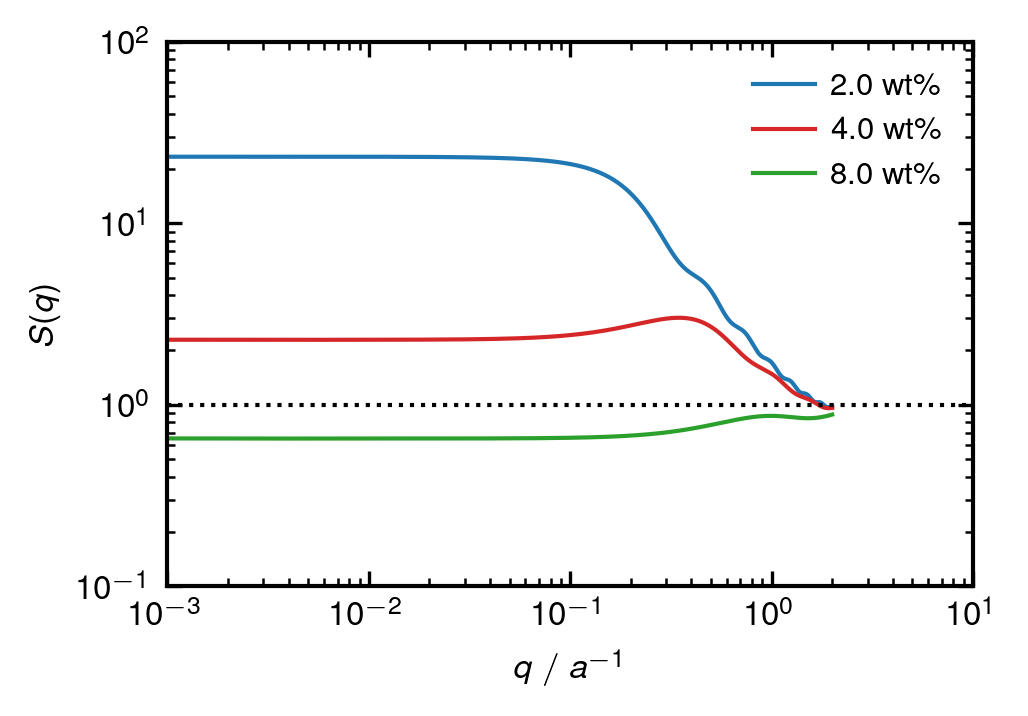

In [10]:
@mpltex.acs_decorator
def myplot():
    fig, ax = plt.subplots(1)
    fig.dpi = 300
    
    linestyles = mpltex.linestyles()
    
    for i in range(len(idx_selected)):
        color = next(linestyles)["color"]
        ax.plot(q_all[i], sq_all[i], label=labels[i], color=color)
    ax.axhline(y=1, linestyle=":", color="k")
    ax.set_xlabel(r"$q~/~a^{-1}$")
    ax.set_ylabel(r"$S(q)$")
    #ax.set_ylim((2, 2.1))
    ax.locator_params(nbins=5)  # limit the number of major ticks
    ax.legend(loc='best')  # show legend in a best location
    ax.set_yscale("log")
    ax.set_xscale("log")
    fig.tight_layout(pad=0.1)  # make layout as tight as possible
    #fig.savefig(figpath + f"Sq_mesh_long_tracer3a.png")
    plt.show()

myplot()

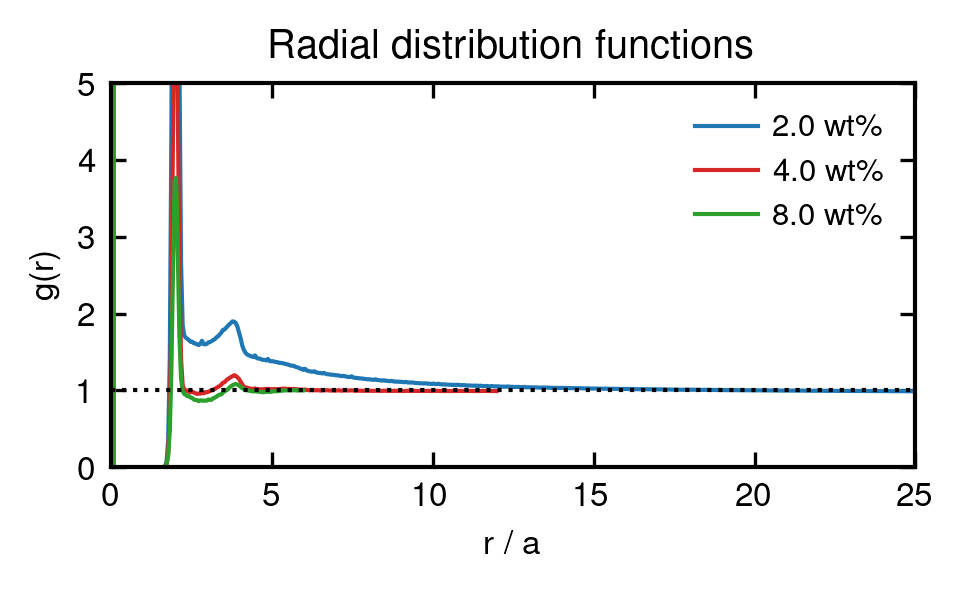

In [12]:
@mpltex.acs_decorator
def myplot():
    fig, ax = plt.subplots(1)
    fig.dpi = 300
    fig.set_size_inches(w=3.25, h=0.75*3.25/1.618)
    
    linestyles = mpltex.linestyles()
    
    for i in range(len(idx_selected)):
        color = next(linestyles)["color"]
        ax.plot(r_all[i], gr_all[i], label=labels[i], color=color)
    ax.axhline(y=1, linestyle=":", color="k")
    ax.legend()
    plt.ylim(0,5)
    #plt.xlim(1.8, 9)
    #ax.hlines(1, 0, 13, "k", linestyle='dashed')
    ax.set_title("Radial distribution functions")
    ax.set_xlabel("r / a")
    ax.set_ylabel("g(r)")
    plt.show()
    plt.show()

myplot()

### Calculate Structure factor with FFT and smooth with gaussian filter

In [49]:
def contiFT(t0, dt, data):
    """
    continuos fourier transform
    normalization 1; osc factor -1, int_t0^infty dt exp(-i w t) f(t)
    """
    shap=len(data)
    s = np.fft.fft(data,shap)
    f = np.fft.fftfreq(shap)*2*np.pi/dt
    s *= dt*np.exp(-complex(0,1)*f*t0)
    f = np.fft.fftshift(f)
    s = np.fft.fftshift(s)
    return f/(2*np.pi), s

/local_scratch2/janmak98/conda/conda_envs/mucus/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/local_scratch2/janmak98/conda/conda_envs/mucus/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_260692/1819276632.py:48: RuntimeWarning: invalid value encountered in divide
  Sq = 1 - 4*np.pi * ft.imag/q
/tmp/ipykernel_260692/1819276632.py:48: RuntimeWarning: divide by zero encountered in divide
  Sq = 1 - 4*np.pi * ft.imag/q


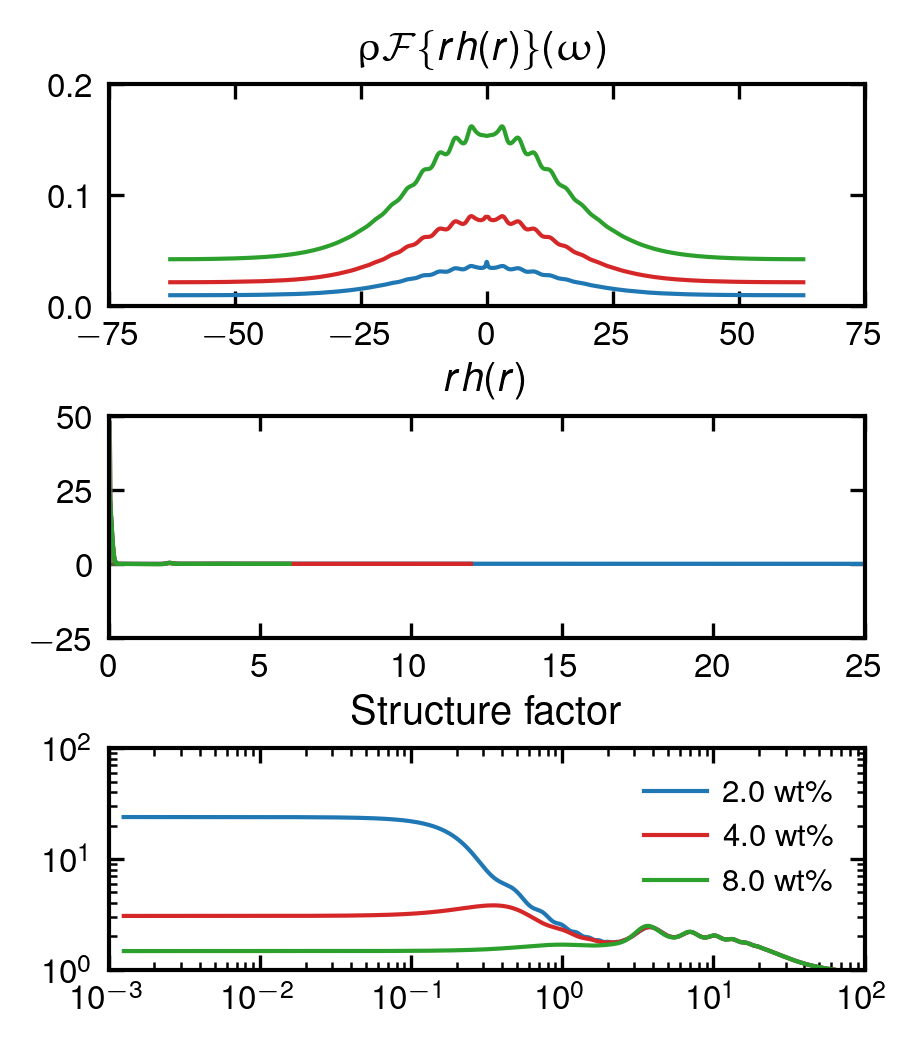

In [54]:
from scipy.ndimage import gaussian_filter1d

q_all_new = []
S_q_all_new = []

@mpltex.aps_decorator
def myplot():
    
    fig, ax = plt.subplots(3)
    fig.dpi = 300
    fig.set_size_inches(w=3.25, h=6.202/1.618)
    linestyles = mpltex.linestyles()
    
    for i in range(len(idx_selected)):
        
        g_r = gr_all[i]
        r = r_all[i]
        rho = rho_all[i]
        
        h_r = g_r - 1
        h_r *= rho
        
        # filter 
        r_h_r = gaussian_filter1d(r*h_r, 1.5)
        
        color = next(linestyles)["color"]
        #r_h_r[r>8]=0
        
        r_new = np.linspace(0, 8, 10*len(r))
        
        # interpolate
        #r_h_r = interp1d(r, r_h_r, kind="cubic",fill_value="extrapolate")(r_new)
        r_old = np.copy(r)
        #r = r_new
        
        q, ft = contiFT(0, r[1]-r[0], np.append(r_h_r, np.zeros(100000)))
        q *= 2*np.pi
        
        ax[0].plot(q, rho*ft, label=labels[i], color=color)
        ax[1].plot(r, r_h_r, label=labels[i], color=color)
        ax[1].plot(r_old, r_old*h_r, label=labels[i], color=color, alpha=0.5)
        #ax[1].set_ylim(0.25, 0.45)
        #ax[1].set_xlim(1.9, 2.1)
        #plt.plot(q, 1 - 4*np.pi*rho *ft.real/q, label=labels[i])
        #plt.plot(q, (1 - 4*np.pi*rho *ft.real/q))
        #plt.plot(q, 1 + 4*np.pi*rho *ft.imag/q)
        ax[2].loglog()
        Sq = 1 - 4*np.pi * ft.imag/q
        ax[2].plot(q, Sq, label=labels[i], color=color)
        q_all_new.append(q)
        S_q_all_new.append(Sq)
        
        ax[0].set_title(r"$\rho \mathcal{F}\{rh(r)\}(\omega)$")
        ax[1].set_title(r"$rh(r)$")
        ax[2].set_title("Structure factor")
    
    # Add whitespace between subplots
    plt.subplots_adjust(hspace=0.5)
    
    plt.legend()
    plt.show()


myplot()

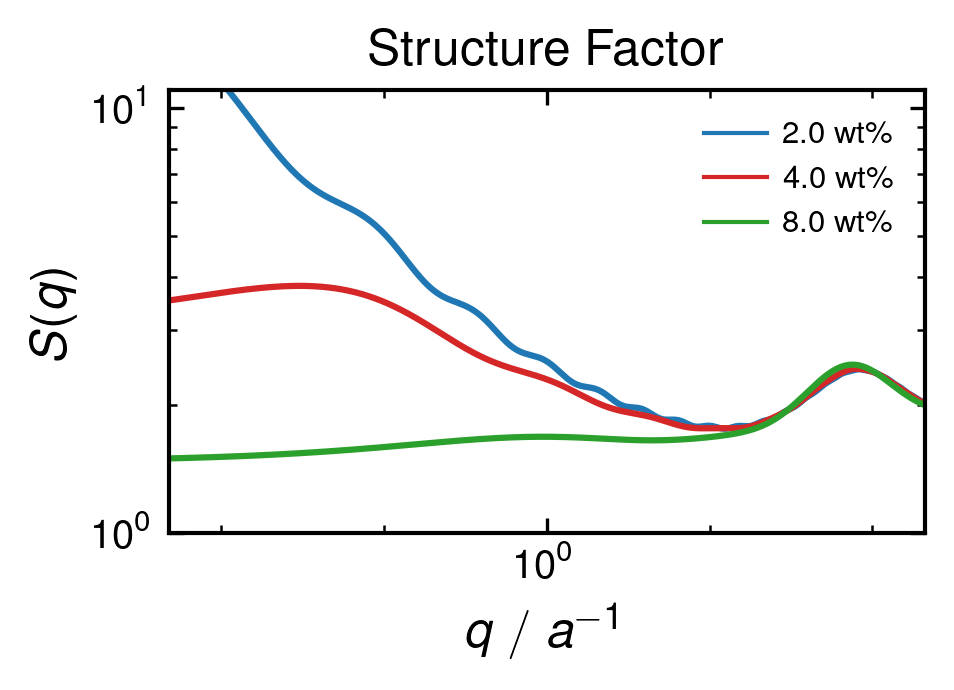

In [59]:
@mpltex.aps_decorator
def plot_Sq_new():
    fontsize = 12
    fig, ax = plt.subplots(1)
    fig.dpi = 300
    fig.set_size_inches(w=3.25, h=6.202/1.618/2)
    linestyles = mpltex.linestyles()

    ax.loglog()
    for Q, S_q, label, rho in zip(q_all_new, S_q_all_new, labels, rho_all):
        ax.plot(Q, S_q, label=label, color = next(linestyles)["color"])

    ax.set_xlim(0.2, 5)
    ax.set_title("Structure Factor")
    ax.set_xlabel(r"$q~/~a^{-1}$")
    ax.set_ylabel(r"$S(q)~/~\mathrm{a.~u.}$")
    ax.set_ylabel(r"$S(q)$")
    
    #ax.axvline(x=2*np.pi/lbox, linestyle=":", color="k", label=r"$2\pi/\mathrm{L_{box}}$", linewidth=1.5)
    #ax.axvline(x=2*np.pi/2, linestyle=":", label=r"$2\pi/2$", linewidth=1.5, color = next(linestyles)["color"])
    #ax.axvline(x=2*np.pi/4, linestyle=":", label=r"$2\pi/4$", linewidth=1.5, color = next(linestyles)["color"])
    
    plt.ylim(1, 11)
    ax.legend()
    ax.tick_params(axis='both', which="both", labelsize=fontsize*0.8)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(fontsize)
    for line in ax.lines:
        line.set_linewidth(1.5)
        
    #ax.tick_params(axis='x', which="minor", labelbottom=False)
    
    ax.xaxis.set_minor_locator(plt.LogLocator(2))
    #plt.savefig('/home/janmak98/Documents/structure_factors.pdf')
    plt.show()

plot_Sq_new()

### SAVE

In [ ]:
# datapath = "/net/data04/janmak98/results/january/growing_mesh/notracer/results"
# names = ["Sq_1wtp.npy", "Sq_2wtp.npy", "Sq_4wtp.npy", "Sq_8wtp.npy"]
# for q, S_q, label in zip(q_all_new, S_q_all_new, names):
#     np.save(datapath + "/" + label, [q, S_q])